In [ ]:
import requests
import os
import pandas as pd
import json
import re
import dotenv
import censusdata
import plotly.express as px
import csv
import geopandas as gpd
import numpy as np
import hvplot.pandas
# import plotly.figure_factory as ff
import plotly.graph_objects as go
import tabulate

dotenv.load_dotenv()
quandl_key = os.getenv('QUANDL_API_KEY')

## 2019 Census Population Data by County
#### Reference: https://www.census.gov/programs-surveys/popest/technical-documentation/file-layouts.html

In [3]:
# read population data
population_df = pd.read_csv(open('co-est2019-alldata.csv'))

# remove results not county
county_df = population_df.loc[population_df['COUNTY'] != 0]

# extract FIPS and set it as index
county_df['FIPS'] = county_df.apply(
    lambda row: str(row['STATE']).zfill(2) + str(row['COUNTY']).zfill(3),
    axis=1
)

county_df.reset_index(inplace=True)
county_df.set_index('FIPS', inplace=True)
county_df.sort_index(inplace=True)
county_df.head()

C:\CustomProgram\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


index  SUMLEV  REGION  DIVISION  STATE  COUNTY   STNAME  \
FIPS                                                             
01001      1      50       3         6      1       1  Alabama   
01003      2      50       3         6      1       3  Alabama   
01005      3      50       3         6      1       5  Alabama   
01007      4      50       3         6      1       7  Alabama   
01009      5      50       3         6      1       9  Alabama   

              CTYNAME  CENSUS2010POP  ESTIMATESBASE2010  ...  \
FIPS                                                     ...   
01001  Autauga County          54571              54597  ...   
01003  Baldwin County         182265             182265  ...   
01005  Barbour County          27457              27455  ...   
01007     Bibb County          22915              22915  ...   
01009   Blount County          57322              57322  ...   

       RDOMESTICMIG2019  RNETMIG2011  RNETMIG2012  RNETMIG2013  RNETMIG2014  \
FIPS                                                                          
01001          4.847310     6.018182    -6.226119    -3.902226     1.970443   
01003         24.017829    16.641870    17.488579    22.751474    20.184334   
01005         -5.690302     0.292676    -6.897817    -8.132185    -5.140431   
01007          1.385134    -4.998356    -3.787545    -5.797999     1.331144   
01009          1.020788     0.208812    -1.650165    -0.347225    -2.049590   

       RNETMIG2015  RNETMIG2016  RNETMIG2017  RNETMIG2018  RNETMIG2019  
FIPS                                                                    
01001    -1.712875     4.777171     0.849656     0.540916     4.560062  
01003    17.725964    21.279291    22.398256    24.727215    24.380567  
01005   -15.724575   -18.238016   -24.998528    -8.754922    -5.165664  
01007     1.329817    -0.708717    -3.234669    -6.857092     1.831952  
01009    -1.338525    -1.391062     6.193562    -0.069229     1.124597  

[5 rows x 165 columns]

## Census TIGER/Line Shapefiles (for Latitude and Longitude)
#### Reference: https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html

In [4]:
# read shp file using geopandas
tiger_df = gpd.read_file('../../../Notebooks/tiger_line_data/tl_2019_us_county.shp')

# GEOID = FIPS
tiger_df.set_index('GEOID', inplace=True)
tiger_df.sort_index(inplace=True)
tiger_df.head()

STATEFP COUNTYFP  COUNTYNS     NAME        NAMELSAD LSAD CLASSFP  MTFCC  \
GEOID                                                                           
01001      01      001  00161526  Autauga  Autauga County   06      H1  G4020   
01003      01      003  00161527  Baldwin  Baldwin County   06      H1  G4020   
01005      01      005  00161528  Barbour  Barbour County   06      H1  G4020   
01007      01      007  00161529     Bibb     Bibb County   06      H1  G4020   
01009      01      009  00161530   Blount   Blount County   06      H1  G4020   

      CSAFP CBSAFP METDIVFP FUNCSTAT       ALAND      AWATER     INTPTLAT  \
GEOID                                                                       
01001   388  33860     None        A  1539602137    25706961  +32.5322367   
01003   380  19300     None        A  4117621645  1132980868  +30.6592183   
01005  None  21640     None        A  2292160139    50523213  +31.8702531   
01007   142  13820     None        A  1612167476     9602089  +33.0158929   
01009   142  13820     None        A  1670103866    15015467  +33.9773575   

           INTPTLON                                           geometry  
GEOID                                                                   
01001  -086.6464395  POLYGON ((-86.90310 32.54063, -86.90311 32.540...  
01003  -087.7460666  POLYGON ((-87.99068 30.55549, -87.99051 30.560...  
01005  -085.4051035  POLYGON ((-85.42982 32.04598, -85.42985 32.046...  
01007  -087.1271475  POLYGON ((-87.31226 33.08622, -87.31218 33.087...  
01009  -086.5664400  POLYGON ((-86.74919 33.99760, -86.74902 33.997...

## Population Density Data Visualization
#### by combining Tiger/Line Land Area and Total Population Data

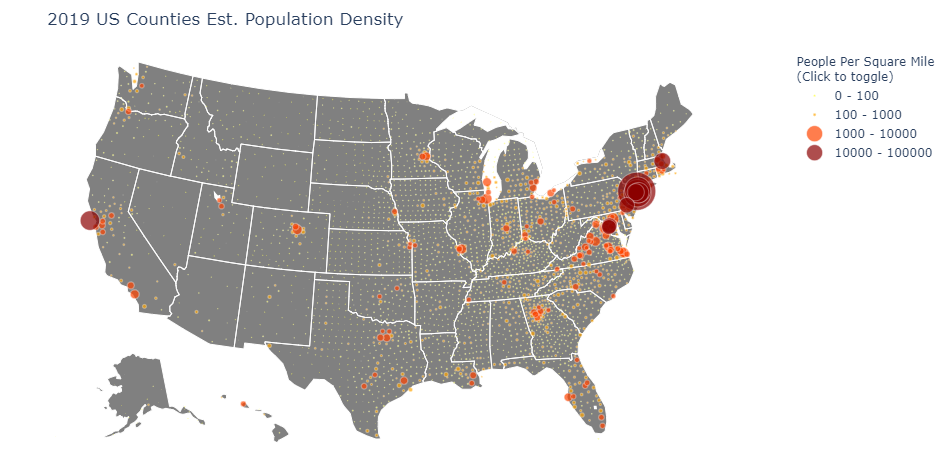

county_name  population_density
36061                   New York County, New York        71874.171308
36047                      Kings County, New York        36901.389855
36005                      Bronx County, New York        33726.519557
36081                     Queens County, New York        20719.750638
06075            San Francisco County, California        18795.232030
34017                   Hudson County, New Jersey        14555.945580
25025               Suffolk County, Massachusetts        13801.327115
42101           Philadelphia County, Pennsylvania        11796.788095
11001  District of Columbia, District of Columbia        11544.005171
51510                   Alexandria city, Virginia        10675.371787

In [5]:
density_df = pd.concat(
    [county_df, tiger_df],
    join = 'inner',
    axis = 1
)

density_df['county_name'] = density_df['CTYNAME'] + ', ' + density_df['STNAME']

# ALAND = sq. km; * 0.386102 to get sq. miles
density_df['population_density'] = (
    density_df['POPESTIMATE2019'] /
    density_df['ALAND'].apply(lambda x: x * 0.386102) * 1000000
)
density_df['lat'] = density_df['INTPTLAT'].apply(lambda x: float(x))
density_df['lon'] = density_df['INTPTLON'].apply(lambda x: float(x))

density_df.sort_values('population_density', ascending=False, inplace=True)

colors = ['darkred', 'orangered', 'orange', 'yellow']
limits = [(100000, 10000), (10000, 1000), (1000, 100), (100, 0)]
density_df['text'] = density_df['CTYNAME'] + '<br>' + (density_df['population_density'].apply(lambda x: round(x))).astype(str)+' Per Square Mile'

pop_density_fig = go.Figure()

for i in reversed(range(len(limits))):
    lim = limits[i]
    df_sub = density_df.loc[(density_df['population_density'] < lim[0]) & (density_df['population_density'] > lim[1])]
    pop_density_fig.add_trace(go.Scattergeo(
        locationmode = 'USA-states',
        lat = df_sub['lat'],
        lon = df_sub['lon'],
        text = df_sub['text'],
        marker = dict(
            size = df_sub['population_density']/100,
            color = colors[i],
            line_color = 'white',
            line_width = 0.5,
            sizemode = 'area'
        ),
        name = '{1} - {0}'.format(lim[0],lim[1])
    ))
    
pop_density_fig.update_layout(
    title_text = '2019 US Counties Est. Population Density',
    legend_title = 'People Per Square Mile<br>(Click to toggle)',
    showlegend = True,
    geo = dict(
        scope = 'usa',
        landcolor = 'gray',
    ),
    margin={'r': 0, 't': 50, 'l': 0, 'b': 0}
)
pop_density_fig.show()
density_df[['county_name', 'population_density']][:10]

## CensusData Python Library
#### (for obtaining Median Home Value/Median Real Estate Tax) reference: https://pypi.org/project/CensusData/

In [6]:
# census api
census_key = os.getenv('CENSUS_API_KEY')

# https://jtleider.github.io/censusdata

# define dataset
dataset = {
    'B25077_001E': 'Median Home Value',
    'B25103_001E': 'Median Real Estate Tax',
    'B25121_001E': 'Median Household Income'
}
census_df = pd.DataFrame()

# download census data while concating data horizontally (2018 is the last year of data available)
for year in range(2012, 2019):
    data = censusdata.download(
        'acs5',
        year,
        censusdata.censusgeo([('county', '*')]),
        list(dataset.keys())
    )
    data['year'] = year
    data
    new_indices = []
    county_names = []
    for index in data.index.tolist():
        new_index = index.geo[0][1] + index.geo[1][1]
        new_indices.append(new_index)
        county_name = index.name.split(':')[0]
        county_names.append(county_name)
    data.index = new_indices
    data['county_name'] = county_names
    data.rename(dataset)
    census_df = pd.concat([census_df, data], axis=0)

census_df.rename(columns=dataset, inplace=True)
census_df['Real Estate Tax Rate'] = census_df['Median Real Estate Tax'] / census_df['Median Home Value']

#### Combine CensusData with TIGER/Line Shapefiles to plot Bubble Map

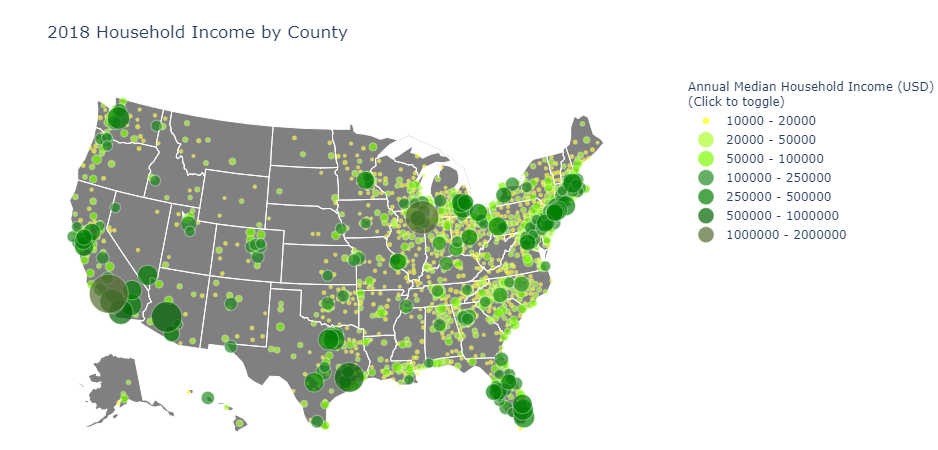

county_name  Median Household Income
06037  Los Angeles County, California                1514629.0
17031           Cook County, Illinois                1116759.0
04013        Maricopa County, Arizona                 933112.0
48201            Harris County, Texas                 865645.0
06073    San Diego County, California                 593890.0
06059       Orange County, California                 592269.0
53033         King County, Washington                 494443.0
06065    Riverside County, California                 472401.0
48113            Dallas County, Texas                 459974.0
12086      Miami-Dade County, Florida                 449056.0

In [7]:
income_df = pd.concat(
    [census_df.loc[census_df['year'] == 2018], tiger_df],
    join = 'inner',
    axis = 1
)

income_df['lat'] = density_df['INTPTLAT'].apply(lambda x: float(x))
income_df['lon'] = density_df['INTPTLON'].apply(lambda x: float(x))

income_df.sort_values('Median Household Income', ascending=False, inplace=True)
colors = ['darkolivegreen', 'darkgreen', 'green', 'forestgreen', 'lawngreen', 'greenyellow', 'yellow']
limits = [(2000000, 1000000), (1000000, 500000), (500000, 250000), (250000, 100000), (100000, 50000), (50000, 20000), (20000, 10000)]
income_df['text'] = income_df['county_name'] + '<br>Median Household Income ' + (income_df['Median Household Income'].apply(lambda x: "${:.1f}K".format(x/1000))).astype(str)

income_fig = go.Figure()

for i in reversed(range(len(limits))):
    lim = limits[i]
    income_sub = income_df.loc[(income_df['Median Household Income'] < lim[0]) & (income_df['Median Household Income'] > lim[1])]
    income_fig.add_trace(go.Scattergeo(
        locationmode = 'USA-states',
        lat = income_sub['lat'],
        lon = income_sub['lon'],
        text = income_sub['text'],
        marker = dict(
            size = income_sub['Median Household Income']/2000,
            color = colors[i],
            line_color = 'white',
            line_width = 0.5,
            sizemode = 'area'
        ),
        name = '{1} - {0}'.format(lim[0],lim[1])
    ))

income_fig.update_layout(
    title_text = '2018 Household Income by County',
    legend_title = 'Annual Median Household Income (USD)<br>(Click to toggle)',
    showlegend = True,
    geo = dict(
        scope = 'usa',
        landcolor = 'gray',
    ),
    margin={"r":0,"t":75,"l":0,"b":0}
)
income_fig.show()
income_df[['county_name', 'Median Household Income']][:10]

## Fetching Zillow Dataset through QUANDL
#### Obtaining both Median Home Value and Price-to-Rent Ratio
#### Focusing on the Counties with both Top 100 Income (Affordability) and Top 100 Population Density (Demand)
##### Reference Quandl Zillow Research Documentation
##### https://www.quandl.com/data/ZILLOW-Zillow-Real-Estate-Research/documentation

In [8]:
# function for calling quandl zillow api
def fetch_zillow_quandl(quandl_code, quandl_key):
    url = f'https://www.quandl.com/api/v3/datasets/ZILLOW/{quandl_code}?start_date=2012-01-01&end_date=2018-12-31&api_key={quandl_key}'
    try:
        response = json.loads(
            requests.get(url).content
        )
        return response['dataset']['data'] if 'quandl_error' not in response else None
    except:
        return None

# State = S
# County = CO
# Greater Metropolitan Area = M
# City = C
# Neighborhood = N
# Zip Code = Z

# function for defining zillow code
def zillow_codes(path, delimiter):
    csv_data = csv.DictReader(open(path), delimiter=delimiter)
    return list(map(lambda x: dict(x), csv_data))

city_lookup = zillow_codes('Quandl_Zillow_Research/city.txt', '|')
county_lookup = zillow_codes('Quandl_Zillow_Research/county.txt', '|')
metro_lookup = zillow_codes('Quandl_Zillow_Research/metro.txt', '|')
state_lookup = zillow_codes('Quandl_Zillow_Research/state.txt', '|')
neighborhood_lookup = zillow_codes('Quandl_Zillow_Research/neighborhood.txt', '|')
indicators_lookup = zillow_codes('Quandl_Zillow_Research/indicators.csv', '|')

def match_locale_name(ctyname, lookup, level):
    ctyname = ctyname.lower().replace('st. ', 'saint ').replace("'s", '')
    matched_list = sorted(
        list(filter(lambda x: ctyname in x['AREA'].lower(), lookup)),
        key = lambda i: i['CODE']
    )
    return f"{level}{matched_list[0]['CODE']}" if matched_list else None

density_df['zcode'] = density_df['CTYNAME'].apply(
    lambda x: match_locale_name(x, county_lookup, 'CO')
)

### Find counties that are both top 100 in income and population density

In [108]:
top_100_county = pd.concat([income_df[:100], density_df[:100]], join='inner', axis=1).drop_duplicates()
top_100_county = top_100_county.loc[:,~top_100_county.columns.duplicated()]
top_100_county[['county_name', 'Median Household Income', 'population_density']]

county_name  Median Household Income  \
06037      Los Angeles County, California                1514629.0   
17031               Cook County, Illinois                1116759.0   
48201                Harris County, Texas                 865645.0   
06059           Orange County, California                 592269.0   
48113                Dallas County, Texas                 459974.0   
12011             Broward County, Florida                 423316.0   
48439               Tarrant County, Texas                 422710.0   
26163              Wayne County, Michigan                 419567.0   
36103            Suffolk County, New York                 390897.0   
25017     Middlesex County, Massachusetts                 374413.0   
48029                 Bexar County, Texas                 372033.0   
36059             Nassau County, New York                 359301.0   
42003      Allegheny County, Pennsylvania                 348200.0   
36081             Queens County, New York                 347739.0   
42101   Philadelphia County, Pennsylvania                 315097.0   
39035               Cuyahoga County, Ohio                 314766.0   
27053          Hennepin County, Minnesota                 314239.0   
06001          Alameda County, California                 305134.0   
06067       Sacramento County, California                 300082.0   
36047              Kings County, New York                 285330.0   
29189          St. Louis County, Missouri                 278370.0   
39049               Franklin County, Ohio                 269515.0   
51059            Fairfax County, Virginia                 268346.0   
12103            Pinellas County, Florida                 268015.0   
06013     Contra Costa County, California                 257528.0   
26099             Macomb County, Michigan                 250757.0   
12095              Orange County, Florida                 250719.0   
17043             DuPage County, Illinois                 250135.0   
49035              Salt Lake County, Utah                 246459.0   
24031         Montgomery County, Maryland                 242263.0   
37119  Mecklenburg County, North Carolina                 227899.0   
42091     Montgomery County, Pennsylvania                 225434.0   
34003           Bergen County, New Jersey                 217881.0   
36119        Westchester County, New York                 212889.0   
13121              Fulton County, Georgia                 206043.0   
18097              Marion County, Indiana                 199179.0   
39061               Hamilton County, Ohio                 196427.0   
24033    Prince George's County, Maryland                 191562.0   
21111          Jefferson County, Kentucky                 191339.0   
13135            Gwinnett County, Georgia                 191178.0   
55079         Milwaukee County, Wisconsin                 189080.0   
25009         Essex County, Massachusetts                 187549.0   
36061           New York County, New York                 182949.0   
25021       Norfolk County, Massachusetts                 182313.0   
34023        Middlesex County, New Jersey                 179974.0   
17097               Lake County, Illinois                 179473.0   
13067                Cobb County, Georgia                 178162.0   
41051            Multnomah County, Oregon                 174421.0   
15003             Honolulu County, Hawaii                 173697.0   
06081        San Mateo County, California                 156864.0   
13089              DeKalb County, Georgia                 150840.0   

       population_density  
06037         2473.508471  
17031         5450.386830  
48201         2762.550471  
06059         4005.618461  
48113         3021.083961  
12011         1623.500657  
48439         2434.431357  
26163         2859.435569  
36103         1619.424024  
25017         1970.650657  
48029         1615.370477  
36059         4767.278979  
42003         1665.548665

In [109]:
select_indicators = ['MVALFAH', 'PRRAH']

for indicator in select_indicators:
    top_100_county[indicator] = top_100_county['zcode'].apply(
        lambda x: fetch_zillow_quandl(f'{x}_{indicator}', quandl_key)
    )

## Plotting the key indicators

In [110]:
def housing_plot(top_100_county):
    
    import panel as pn
    from panel.interact import interact
    pn.extension()

    def county_plot(County='New York County, New York'):
        mvalfah_headers = ['date', 'value']
        mvalfah = pd.DataFrame(list(top_100_county.loc[top_100_county['county_name'] == County]['MVALFAH'].to_list()[0]), columns=mvalfah_headers)
        mvalfah['date'] = mvalfah['date'].astype('datetime64[ns]')
        mvalfah.set_index('date', inplace = True)
        mvalfah.sort_index(inplace = True)
        
        prrah_headers = ['date', 'ratio']
        prrah = pd.DataFrame(list(top_100_county.loc[top_100_county['county_name'] == County]['PRRAH'].to_list()[0]), columns=prrah_headers)
        prrah['date'] = prrah['date'].astype('datetime64[ns]')
        prrah.set_index('date', inplace = True)
        prrah.sort_index(inplace = True)
        
        real_estate_tax_headers = ['date', 'rate']
        real_estate_tax = census_df.loc[census_df['county_name'] == County][['year', 'Real Estate Tax Rate']]
        real_estate_tax.set_index('year', inplace = True)
        real_estate_tax.sort_index(inplace = True)
        
        mvalfah_plot = mvalfah.hvplot.line(
            x = 'date',
            xlabel = 'Date',
            y = 'value',
            yaxis = 'left',
            ylabel = 'Per Square Foot (USD)',
            title = 'Median Home Value',
            width = 500
        )
        
        prrah_plot = prrah.hvplot.line(
            x = 'date',
            xlabel = 'Date',
            y = 'ratio',
            yaxis = 'left',
            ylabel = 'Home Price / Annual Rent',
            title = 'Price to Rent Ratio',
            width = 500
        )
        
        real_estate_tax_plot = real_estate_tax.hvplot.line(
            x = 'year',
            xlabel = 'Date',
            y = 'Real Estate Tax Rate',
            yaxis = 'left',
#             ylabel = 'Home Price / Annual Rent',
            title = 'Real Estate Tax Rate',
            width = 500
        )
        
        return mvalfah_plot + prrah_plot + real_estate_tax_plot

    return interact(county_plot, County=sorted(list(top_100_county['county_name'])))

In [111]:
housing_plot(top_100_county)

Column
    [0] Column
        [0] Select(name='County', options=['Alameda County, ...], value='New York County, ...)
    [1] Row
        [0] HoloViews(Layout, name='interactive44315')

## With 1 million dollar in 2012, which county performed the best 

In [129]:
top_100_county['appreciation_1m'] = top_100_county['MVALFAH'].apply(
    lambda x: 1000000*(x[0][1]/x[-1][1])
)
top_100_county['income_1m'] = top_100_county['PRRAH'].apply(
    lambda x: sum(map(lambda y: 1000000/(y[1]*12), x))
)
top_100_county['expense_1m'] = top_100_county['county_name'].apply(
    lambda x: sum(map(
        lambda tax_rate: 1000000*tax_rate,
        list(census_df.loc[census_df['county_name'] == x]['Real Estate Tax Rate'])
    ))
)
top_100_county['total_proceeds'] = top_100_county['appreciation_1m'] + top_100_county['income_1m'] - top_100_county['expense_1m']
top_100_county['total_proceeds'] = top_100_county['total_proceeds'].astype('int64')
top_100_county.sort_values('total_proceeds', ascending=False, inplace=True)
top_100_county.head(10)[['county_name', 'total_proceeds']]

county_name  total_proceeds
26163           Wayne County, Michigan         3169917
26099          Macomb County, Michigan         2553875
13089           DeKalb County, Georgia         2522056
06001       Alameda County, California         2500199
12011          Broward County, Florida         2489344
06067    Sacramento County, California         2479974
12103         Pinellas County, Florida         2470103
48113             Dallas County, Texas         2449902
06081     San Mateo County, California         2434182
06013  Contra Costa County, California         2421438

## Getting Neighhorhood Level Zillow Data
#### Reference: https://data.opendatasoft.com/explore/dataset/zillow-neighborhoods%40public/export/

In [ ]:
mapbox_token = os.getenv('MAPBOX_API_KEY')

geo_df = gpd.read_file('zillow-neighborhoods.geojson')

In [136]:
top_100_county['county'] = top_100_county['county_name'].apply(
    lambda x: x.split(' County, ')[0]
)

# Identify all neighborhoods within the counties in the previous section
neighborhood_df = geo_df.loc[geo_df['county'].isin(list(top_100_county.head(10)['county']))]

neighborhood_df['zcode'] = neighborhood_df['name'].apply(
    lambda x: match_locale_name(x, neighborhood_lookup, 'N')
)
neighborhood_df.dropna(inplace=True)

C:\CustomProgram\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\CustomProgram\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [137]:
neighborhood_df

city                        name regionid    county state  \
3        Pompano Beach               Kendall Green   124914   Broward    FL   
5        Pompano Beach                  Lyons Park   125172   Broward    FL   
19     Fort Lauderdale  Hendricks and Venice Isles   273961   Broward    FL   
21     Fort Lauderdale                 Shady Banks   269179   Broward    FL   
26          Clearwater              Winding Wood 2   343283  Pinellas    FL   
...                ...                         ...      ...       ...   ...   
17038       Richardson                Heights Park   416923    Dallas    TX   
17040          Garland       Oakridge on the Creek   274860    Dallas    TX   
17043          Garland          Valley Creek North   275843    Dallas    TX   
17045          Garland               Village Green   275873    Dallas    TX   
17048          Garland                   Wood Glen   276666    Dallas    TX   

                                                geometry   zcode  
3      POLYGON ((-80.11791 26.26049, -80.12197 26.246...  N18306  
5      POLYGON ((-80.12318 26.21111, -80.13248 26.210...  N12292  
19     POLYGON ((-80.12101 26.12943, -80.12080 26.129...  N12399  
21     POLYGON ((-80.15904 26.10720, -80.15903 26.106...  N17463  
26     POLYGON ((-82.72450 28.01581, -82.72455 28.015...  N25655  
...                                                  ...     ...  
17038  POLYGON ((-96.73893 32.96131, -96.73894 32.960...  N16576  
17040  POLYGON ((-96.66870 32.93219, -96.66821 32.932...  N26859  
17043  POLYGON ((-96.60146 32.94728, -96.60112 32.946...  N23457  
17045  POLYGON ((-96.67592 32.95142, -96.67592 32.950...   N1028  
17048  POLYGON ((-96.66337 32.96700, -96.66300 32.966...  N16815  

[1240 rows x 7 columns]

In [138]:
# geo_df.loc[geo_df['county'] == 'Cook'].plot(column='regionid', figsize=(100,50))
for indicator in select_indicators:
    neighborhood_df[indicator] = neighborhood_df['zcode'].apply(
        lambda x: fetch_zillow_quandl(f'{x}_{indicator}', quandl_key)
    )

C:\CustomProgram\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [139]:
neighborhood_df.dropna(inplace=True)
neighborhood_df

C:\CustomProgram\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



city                        name regionid     county state  \
3         Pompano Beach               Kendall Green   124914    Broward    FL   
5         Pompano Beach                  Lyons Park   125172    Broward    FL   
19      Fort Lauderdale  Hendricks and Venice Isles   273961    Broward    FL   
21      Fort Lauderdale                 Shady Banks   269179    Broward    FL   
32      Fort Lauderdale                      Sunset   275630    Broward    FL   
...                 ...                         ...      ...        ...   ...   
10243        Richardson          North College Park   416929     Dallas    TX   
10437   Fort Lauderdale            Durrs Homeowners   273517    Broward    FL   
10441  Saint Petersburg       Thirteenth St Heights   417144   Pinellas    FL   
10443         Hollywood                441 Corridor   623401    Broward    FL   
10555         San Mateo                   Westshore   343952  San Mateo    CA   

                                                geometry   zcode  \
3      POLYGON ((-80.11791 26.26049, -80.12197 26.246...  N18306   
5      POLYGON ((-80.12318 26.21111, -80.13248 26.210...  N12292   
19     POLYGON ((-80.12101 26.12943, -80.12080 26.129...  N12399   
21     POLYGON ((-80.15904 26.10720, -80.15903 26.106...  N17463   
32     POLYGON ((-80.18840 26.10288, -80.19095 26.102...  N10334   
...                                                  ...     ...   
10243  POLYGON ((-96.70893 32.94536, -96.70882 32.945...  N12643   
10437  POLYGON ((-80.16568 26.13668, -80.16549 26.136...  N18785   
10441  POLYGON ((-82.64897 27.75931, -82.64877 27.759...  N19028   
10443  MULTIPOLYGON (((-80.20751 26.03439, -80.20737 ...  N12689   
10555  POLYGON ((-122.28775 37.55258, -122.28723 37.5...  N15930   

                                                 MVALFAH  \
3      [[2018-12-31, 725.0], [2018-11-30, 721.0], [20...   
5      [[2018-12-31, 237.0], [2018-11-30, 236.0], [20...   
19     [[2018-12-31, 400.0], [2018-11-30, 398.0], [20...   
21     [[2018-12-31, 273.0], [2018-11-30, 271.0], [20...   
32     [[2018-12-31, 328.0], [2018-11-30, 327.0], [20...   
...                                                  ...   
10243  [[2018-12-31, 1576.0], [2018-11-30, 1595.0], [...   
10437  [[2018-12-31, 157.0], [2018-11-30, 156.0], [20...   
10441  [[2018-12-31, 94.0], [2018-11-30, 92.0], [2018...   
10443  [[2018-12-31, 213.0], [2018-11-30, 211.0], [20...   
10555  [[2018-12-31, 1102.0], [2018-11-30, 1108.0], [...   

                                                   PRRAH  
3      [[2018-12-31, 10.61], [2018-11-30, 10.64], [20...  
5      [[2018-12-31, 11.9], [2018-11-30, 11.98], [201...  
19     [[2018-12-31, 13.08], [2018-11-30, 13.48], [20...  
21     [[2018-12-31, 12.54], [2018-11-30, 12.76], [20...  
32     [[2018-12-31, 23.8], [2018-11-30, 23.89], [201...  
...                                                  ...  
10243  [[2018-12-31, 21.39], [2018-11-30, 22.18], [20...  
10437  [[2018-12-31, 8.59], [2018-11-30, 8.89], [2018...  
10441  [[2018-12-31, 8.13], [2018-11-30, 7.6], [2018-...  
10443  [[2018-12-31, 11.13], [2018-11-30, 11.17], [20...  
10555  [[2018-12-31, 25.69], [2018-11-30, 24.1], [201...  

[342 rows x 9 columns]

In [147]:
neighborhood_df['geometry']

3        POLYGON ((-80.11791 26.26049, -80.12197 26.246...
5        POLYGON ((-80.12318 26.21111, -80.13248 26.210...
19       POLYGON ((-80.12101 26.12943, -80.12080 26.129...
21       POLYGON ((-80.15904 26.10720, -80.15903 26.106...
32       POLYGON ((-80.18840 26.10288, -80.19095 26.102...
                               ...                        
10243    POLYGON ((-96.70893 32.94536, -96.70882 32.945...
10437    POLYGON ((-80.16568 26.13668, -80.16549 26.136...
10441    POLYGON ((-82.64897 27.75931, -82.64877 27.759...
10443    MULTIPOLYGON (((-80.20751 26.03439, -80.20737 ...
10555    POLYGON ((-122.28775 37.55258, -122.28723 37.5...
Name: geometry, Length: 342, dtype: geometry

In [ ]:
geo_fig = go.Figure(
    go.Choroplethmapbox(
        geojson=geo_df,
#         locations=geo_df['regionid'],
#         z=geo_df['regionid'],
        colorscale='Cividis',
        zmin=0,
        zmax=17,
        marker_line_width=3
    )
)

geo_fig.update_layout(mapbox_style='carto-positron')
geo_fig.show()

In [42]:
from pytrends.request import TrendReq
import time
startTime = time.time()
pytrend = TrendReq(hl='en-US', tz=360)
pytrend.build_payload(kw_list=['Open House'])
df = pytrend.interest_by_region()
df.loc[df['Open House'] != 0].sort_values(by='Open House', ascending=False)

Open House
geoName                         
Singapore                    100
Canada                        49
United States                 43
Ireland                       29
Australia                     27
United Kingdom                27
Thailand                      19
Malaysia                      16
South Africa                  14
New Zealand                   14
Kenya                         12
Philippines                   11
Greece                         9
Austria                        8
United Arab Emirates           8
Portugal                       7
Pakistan                       7
Mexico                         6
Czechia                        6
Switzerland                    6
India                          6
Hong Kong                      6
Indonesia                      5
Sweden                         4
Netherlands                    4
Italy                          4
Hungary                        4
Spain                          4
Argentina                      3
Germany                        3
Brazil                         3
Belgium                        3
Poland                         2
Taiwan                         2
France                         2
Colombia                       2
Japan                          1
Turkey                         1
Vietnam                        1

In [33]:
# kaggle https://github.com/Kaggle/kaggle-api#api-credentials